<a href="https://colab.research.google.com/github/RaulAtLehigh/CSE337_P1/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


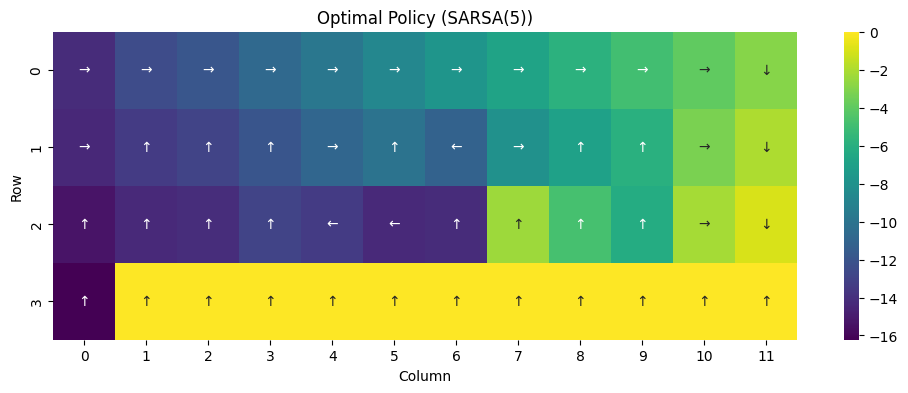

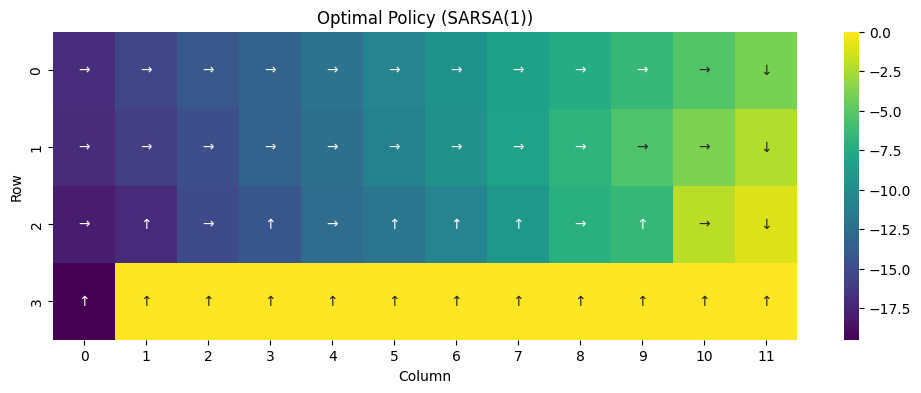

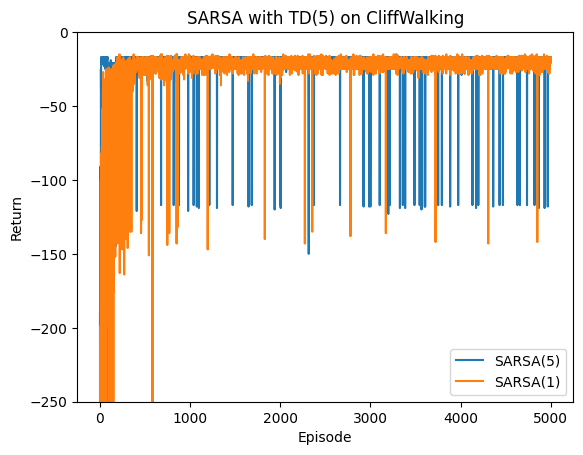

In [39]:



"""
 Starter code for Exercise (you can use this code, or extend your code from previous lab)
 Implement SARSA with TD(5) on CliffWalking-v1
 """

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Optimal Policy (" + title + ")")
  plt.show()

# Environment
env = gym.make("CliffWalking-v1") # create environment

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = .04
n_step = 5            # number of steps for TD(n)
n_episodes = 5000

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []

for ep in range(n_episodes): # Loop for each episode
    state, _ = env.reset() # s
    action = epsilon_greedy(state) # a

    # Buffers to store the trajectory
    states = deque([state])
    actions = deque([action])
    rewards = deque()

    T = float("inf")
    t = 0

    while True:
        if t < T:
            # Take real step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store the reward and the next state/action
            rewards.append(reward)
            states.append(next_state)

            if done:
                T = t + 1
            else:
                next_action = epsilon_greedy(next_state)
                actions.append(next_action)
                state = next_state
                action = next_action

        # Time index for state/action to update
        tau = t - n_step + 1
        if tau >= 0:
            G = 0.0
            # Accumulate discounted rewards for n steps
            for i in range(n_step):
                if tau + i < len(rewards):
                    G += (gamma ** i) * rewards[tau + i]

            # Add the bootstrap value if not terminal
            if tau + n_step < T:
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # Update Q-value
            s_tau = states[tau]
            a_tau = actions[tau]
            Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

        if tau == T - 1: # Break when the update for the last state is done
            break

        t += 1

    # Calculate total return for the episode for plotting
    # Note: Using `len(rewards)` as it directly reflects steps taken.
    episode_returns.append(sum(rewards))
plot_policy(Q, "SARSA(5)")

# Now adding my one step sarsa from last class:

env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5000     # number of episodes to run
max_steps = 100     # safety cap
sarsaRewards = np.zeros(n_episodes)
# Q-learning parameters
learning_rate = 0.1 # alpha
discount_factor = 0.99 # lambda
n_actions = env.action_space.n
n_states = env.observation_space.n
Q = np.zeros((n_states, n_actions))

def greedyPolicy(state, Q): # assuming I can index by state
  return np.argmax(Q[state])

# call using action = self.greedyPolicy()


"""
if(step % (max_steps * epsilon) == 0):
      action = env.action_space.sample()
"""

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    action = greedyPolicy(state, Q)
    next_action = 0
    for step in range(max_steps):
        next_state, reward, terminated, truncated, info = env.step(action)
        # e-greedy policy
        if(step % (max_steps * epsilon) == 0):
          next_action = env.action_space.sample() # random for this one
        else:
          next_action = greedyPolicy(next_state, Q)
        total_reward += reward
        Q[state][action] = Q[state][action] + learning_rate* ((reward + discount_factor * (Q[next_state][next_action])) - Q[state][action])
        state = next_state
        action = next_action

        if terminated or truncated:
            break

    #print(f"Episode {episode+1}: total reward = {total_reward}")
    sarsaRewards[episode] = total_reward

env.close()
plot_policy(Q, "SARSA(1)")
# Plot learning curve
plt.plot(episode_returns)
plt.plot(sarsaRewards)
plt.legend(["SARSA(5)", "SARSA(1)"])
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title(f"SARSA with TD({n_step}) on CliffWalking")
plt.ylim([-250, 0])

plt.show()






**Discussion on Sarsa(1) vs Sarsa(5):**

It seems that 5-step sarsa converges much quicker for this cliff-walking example than simple 1-step sarsa. As you can see on the top left corner, the blue graph (sarsa(5)) has already reached a desirearble return whereas 1-step sarsa took much longer. I think this was expected, because as you take more steps into consideration, you can make more informed value predictions that you do when you just take one value and update the Q table.

With respect to the policy derived from the two separate methods, Sarsa 5 seems to take the middle path as opposed to regular Sarsa taking the top path for the majority of the policy. This shows that Sarsa(5) was less susceptible to the outliers that come from greedy epsilon strategy. This makes sense since taking more values into consideration when calculating the Q function lowers the significance of an outlier (like falling off the graph when chosing a random step).

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
> This method is much more aggressive, as it hugs the path closest to the curve. The simulation steps assure that walking next to a cliff doesn't necessairily mean falling into it.

4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
> There definitely are diminishing returns to exploring the model more, especially in the early portions of the early episodes since we haven't visited many states and action pairs to even simulate much. For this example, n =20 seemed to be a bit better than n= 50 which is counterintuitive to what I was thinking. I think this is the reason why my n=20 model reached the threshold quicker than the n = 50, ... perhaps n = 50 hallucinates at some point.

5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




Starting Dyna-Q with n =  5


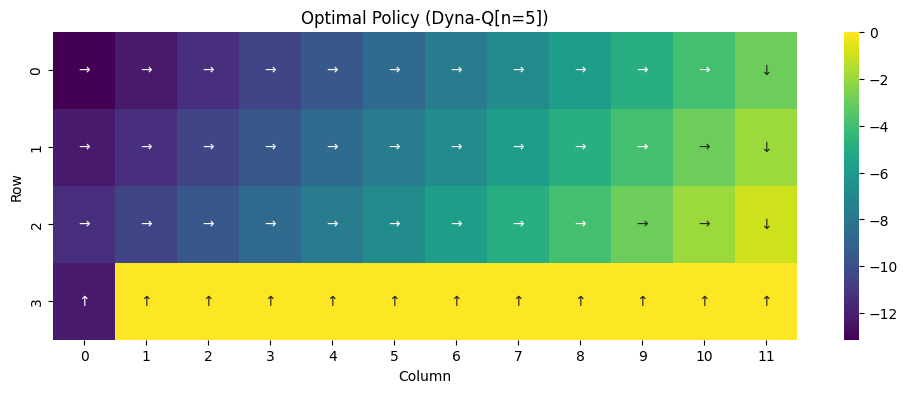

Part C - 2: Dyna-Q with n=5 surpassed threshold (-30) at Episode: 111
Starting Dyna-Q with n =  20


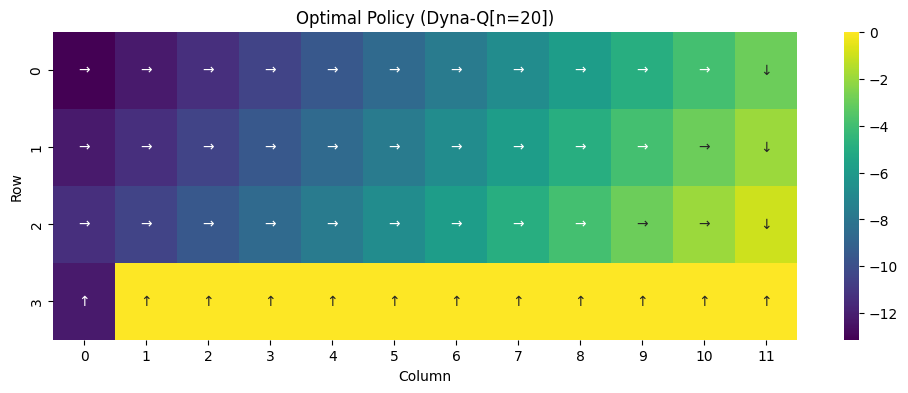

Part C - 2: Dyna-Q with n=20 surpassed threshold (-30) at Episode: 101
Starting Dyna-Q with n =  50


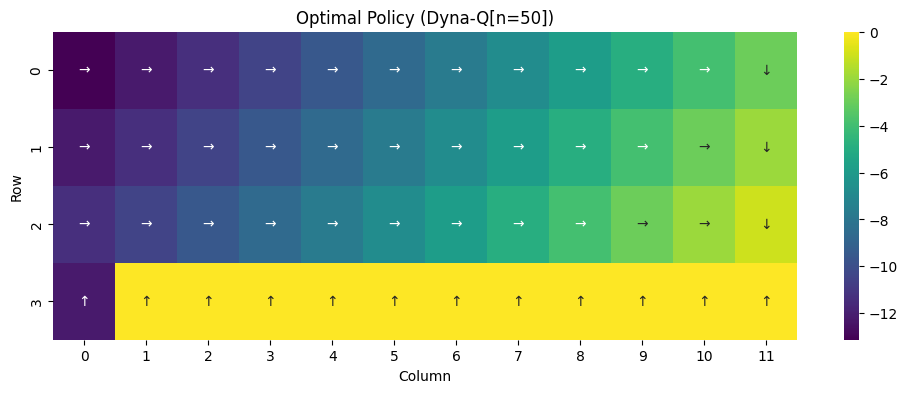

Part C - 2: Dyna-Q with n=50 surpassed threshold (-30) at Episode: 101


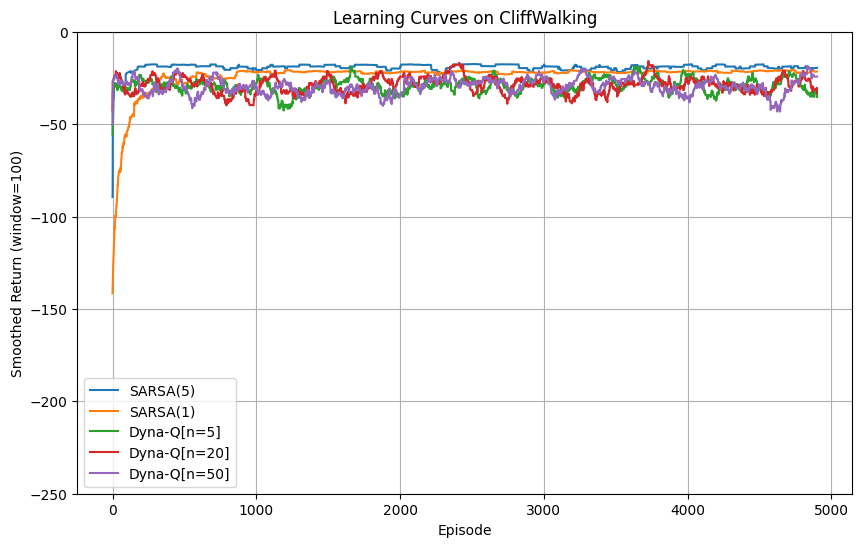

In [43]:
# Implementing Dyna-Q

# Environment
env = gym.make("CliffWalking-v1") # create environment

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.05         # epsilon for epsilon-greedy policy
n_episodes = 5000
n_loops_list = [5, 20, 50] # Renamed to avoid conflict
window_size = 100
threshold = -30 # Define the threshold

# Initialize Q-table
Q = np.zeros((n_states, n_actions))
# initialize model table
Model =  np.zeros((n_states, n_actions), dtype=object) # Use dtype=object to store dictionaries

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# the first state
Dyna_Q_returns = []
for n_loops in n_loops_list: # Iterate over different n_loops values
  current_dyna_q_returns = [] # Store returns for the current n_loops
  observed_transitions = [] # resetting the observed transitions
  # Initialize Q-table for each run
  Q = np.zeros((n_states, n_actions))
  # initialize model table for each run
  Model =  np.zeros((n_states, n_actions), dtype=object) # Use dtype=object to store dictionaries
  print("Starting Dyna-Q with n = ", n_loops)

  for ep in range(n_episodes): # Loop for each episode
    total_reward = 0
    state, _ = env.reset() # s
    while(True): # Loop Forever
      action = epsilon_greedy(state)
      # Take action A; observe resultant R and S'
      next_state, reward, terminated, truncated, _ = env.step(action)
      total_reward += reward
      #update Q-table
      Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])
      # Add unique state action pairs to observed_transitions
      if {"state": state, "action": action} not in observed_transitions:
          observed_transitions.append({"state": state, "action": action})

      # update the model
      Model[state, action] = {"Reward": reward, "newState": next_state}
      for n in range(0, n_loops):
        if len(observed_transitions) > 0: # Ensure there's at least one observed transition
            randIndex = np.random.randint(0, len(observed_transitions))
            randTransition = observed_transitions[randIndex]
            # S <- random previously observed State
            modelState = randTransition["state"]
            # A <- random action previously taken in S
            modelAction = randTransition["action"]
            #R,S' <- Model(S,A)
            modelReward = Model[modelState, modelAction]["Reward"]
            modelNextState = Model[modelState, modelAction]["newState"]
            #update the Q function
            Q[modelState, modelAction] = Q[modelState, modelAction] + alpha * (modelReward + gamma * np.max(Q[modelNextState, :]) - Q[modelState, modelAction])
      # letting the model be simulated even if we're at the end, this hsould make it better for future episodes
      state = next_state
      if(terminated or truncated):
        break;

    current_dyna_q_returns.append(total_reward)
  Dyna_Q_returns.append(current_dyna_q_returns)
  plot_policy(Q, f"Dyna-Q[n={n_loops}]")

  # --- Threshold check moved here ---
  smoothed_current_returns = np.convolve(current_dyna_q_returns, np.ones(window_size)/window_size, mode='valid')
  # Find the first episode where the smoothed return exceeds the threshold
  threshold_episode = -1
  for i in range(len(smoothed_current_returns)):
      if smoothed_current_returns[i] > threshold:
          threshold_episode = i + window_size -1 # Adjust for window offset
          break
  print(f"Part C - 2: Dyna-Q with n={n_loops} surpassed threshold ({threshold}) at Episode: {threshold_episode}")


# Part- B : Baselines (assuming this part is from a previous cell and its outputs are available)

# Dyna-Q creates a bunch of outliers, had Gemini smoothen the results
# Apply rolling average for smoothing
smoothed_episode_returns = np.convolve(episode_returns, np.ones(window_size)/window_size, mode='valid')
smoothed_sarsaRewards = np.convolve(sarsaRewards, np.ones(window_size)/window_size, mode='valid')
smoothed_dyna_q_returns = [np.convolve(returns, np.ones(window_size)/window_size, mode='valid') for returns in Dyna_Q_returns]


# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(smoothed_episode_returns, label="SARSA(5)")
plt.plot(smoothed_sarsaRewards, label="SARSA(1)")
plt.plot(smoothed_dyna_q_returns[0], label=f"Dyna-Q[n={n_loops_list[0]}]")
plt.plot(smoothed_dyna_q_returns[1], label=f"Dyna-Q[n={n_loops_list[1]}]")
plt.plot(smoothed_dyna_q_returns[2], label=f"Dyna-Q[n={n_loops_list[2]}]")

plt.xlabel("Episode")
plt.ylabel("Smoothed Return (window=100)")
plt.title("Learning Curves on CliffWalking")
plt.ylim([-250, 0])
plt.legend()
plt.grid(True)
plt.show()

Starting run with seed 0
Running SARSA(1)
Running SARSA(5)
Running Dyna-Q with n = 5
Running Dyna-Q with n = 20
Running Dyna-Q with n = 50
Starting run with seed 1
Running SARSA(1)
Running SARSA(5)
Running Dyna-Q with n = 5
Running Dyna-Q with n = 20
Running Dyna-Q with n = 50
Starting run with seed 2
Running SARSA(1)
Running SARSA(5)
Running Dyna-Q with n = 5
Running Dyna-Q with n = 20
Running Dyna-Q with n = 50
Starting run with seed 3
Running SARSA(1)
Running SARSA(5)
Running Dyna-Q with n = 5
Running Dyna-Q with n = 20
Running Dyna-Q with n = 50
Starting run with seed 4
Running SARSA(1)
Running SARSA(5)
Running Dyna-Q with n = 5
Running Dyna-Q with n = 20
Running Dyna-Q with n = 50


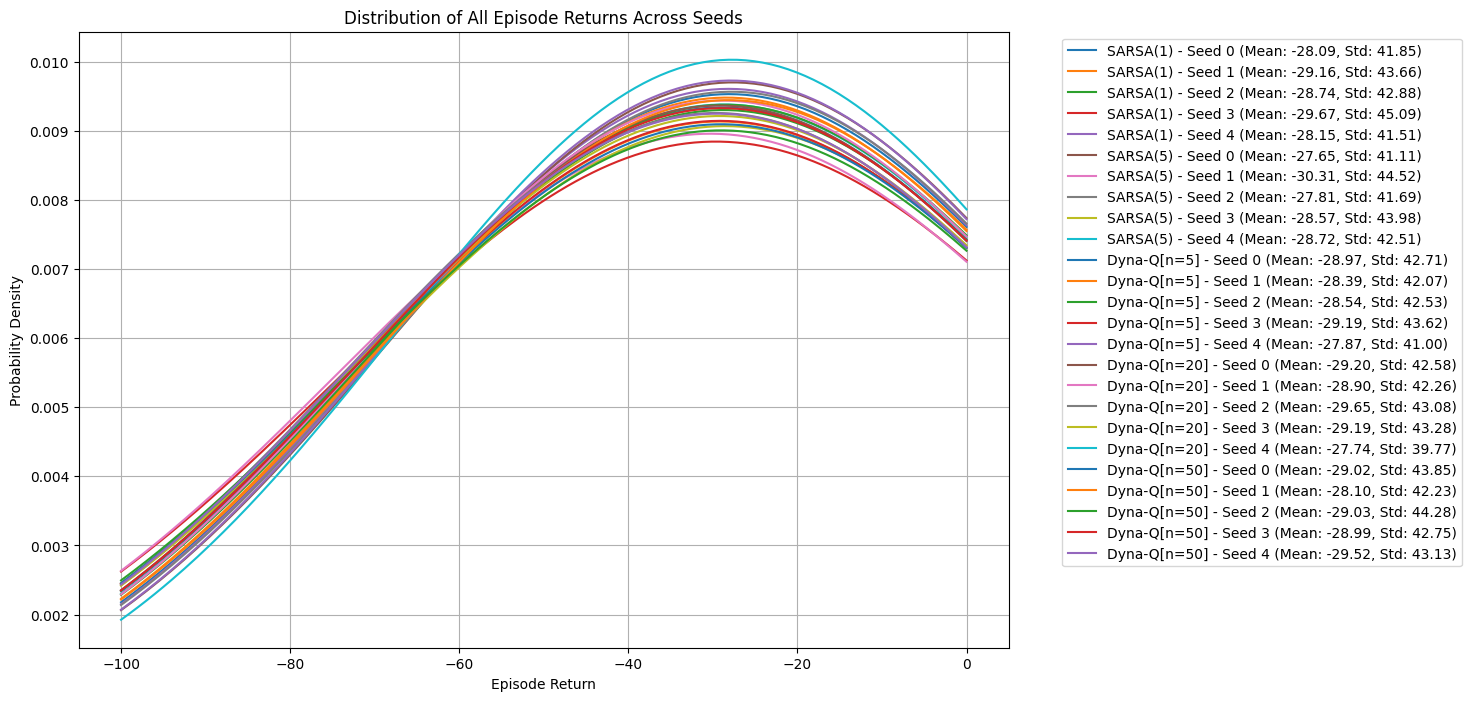


Sample Efficiency (Episode to reach threshold -30):
SARSA(1): Episode 138
SARSA(5): Episode 99
Dyna-Q[n=5]: Episode 99
Dyna-Q[n=20]: Episode 99
Dyna-Q[n=50]: Episode 99


In [45]:
# Implementing Dyna-Q with multiple seeds

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats # Import scipy for normal distribution

def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Optimal Policy (" + title + ")")
  plt.show()


# Environment
env = gym.make("CliffWalking-v1") # create environment

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.05         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 3000
n_loops_list = [5, 20, 50] # Renamed to avoid conflict
window_size = 100
threshold = -30 # Define the threshold
n_seeds = 5 # Number of random seeds

# Store returns for multiple seeds
all_dyna_q_returns = {n_loops: [] for n_loops in n_loops_list}
all_sarsa_1_returns = []
all_sarsa_5_returns = []

for seed in range(n_seeds):
  print(f"Starting run with seed {seed}")
  np.random.seed(seed) # Set random seed for reproducibility

  # --- SARSA(1) ---
  print("Running SARSA(1)")
  Q_sarsa1 = np.zeros((n_states, n_actions))
  sarsa1_returns = []
  env_sarsa1 = gym.make("CliffWalking-v1") # create new env for each run/method
  for ep in range(n_episodes):
      state, _ = env_sarsa1.reset()
      done = False
      total_reward = 0
      action = epsilon_greedy(state) # Using the same epsilon_greedy function
      while not done:
          next_state, reward, terminated, truncated, _ = env_sarsa1.step(action)
          done = terminated or truncated
          total_reward += reward
          # SARSA update
          if not done:
            next_action = epsilon_greedy(next_state)
            Q_sarsa1[state, action] = Q_sarsa1[state, action] + alpha * (reward + gamma * Q_sarsa1[next_state, next_action] - Q_sarsa1[state, action])
            state = next_state
            action = next_action
          else:
             Q_sarsa1[state, action] = Q_sarsa1[state, action] + alpha * (reward - Q_sarsa1[state, action])


      sarsa1_returns.append(total_reward)
  all_sarsa_1_returns.append(sarsa1_returns)
  env_sarsa1.close()


  # --- SARSA(5) ---
  print("Running SARSA(5)")
  Q_sarsa5 = np.zeros((n_states, n_actions))
  sarsa5_returns = []
  env_sarsa5 = gym.make("CliffWalking-v1") # create new env
  for ep in range(n_episodes): # Loop for each episode
      state, _ = env_sarsa5.reset() # s
      action = epsilon_greedy(state) # a

      # Buffers to store the trajectory
      states = deque([state])
      actions = deque([action])
      rewards = deque()

      T = float("inf")
      t = 0

      while True:
          if t < T:
              # Take real step in the environment
              next_state, reward, terminated, truncated, _ = env_sarsa5.step(action)
              done = terminated or truncated

              # Store the reward and the next state/action
              rewards.append(reward)
              states.append(next_state)

              if done:
                  T = t + 1
              else:
                  next_action = epsilon_greedy(next_state)
                  actions.append(next_action)
                  state = next_state
                  action = next_action

          # Time index for state/action to update
          tau = t - n_step + 1
          if tau >= 0:
              G = 0.0
              # Accumulate discounted rewards for n steps
              for i in range(n_step):
                  if tau + i < len(rewards):
                      G += (gamma ** i) * rewards[tau + i]

              # Add the bootstrap value if not terminal
              if tau + n_step < T:
                  s_tau_n = states[tau + n_step]
                  a_tau_n = actions[tau + n_step]
                  G += (gamma ** n_step) * Q_sarsa5[s_tau_n, a_tau_n]

              # Update Q-value
              s_tau = states[tau]
              a_tau = actions[tau]
              Q_sarsa5[s_tau, a_tau] += alpha * (G - Q_sarsa5[s_tau, a_tau])

          if tau == T - 1: # Break when the update for the last state is done
              break

          t += 1

      sarsa5_returns.append(sum(rewards))
  all_sarsa_5_returns.append(sarsa5_returns)
  env_sarsa5.close()


  # --- Dyna-Q with different n_loops ---
  for n_loops in n_loops_list:
    print(f"Running Dyna-Q with n = {n_loops}")
    Q_dyna = np.zeros((n_states, n_actions))
    Model =  np.zeros((n_states, n_actions), dtype=object)
    current_dyna_q_returns = []
    observed_transitions = []
    env_dyna = gym.make("CliffWalking-v1") # create new env

    for ep in range(n_episodes):
      total_reward = 0
      state, _ = env_dyna.reset()
      while(True):
        action = epsilon_greedy(state)
        next_state, reward, terminated, truncated, _ = env_dyna.step(action)
        total_reward += reward
        done = terminated or truncated

        # Real step update (Q-learning style)
        if not done:
            Q_dyna[state, action] = Q_dyna[state, action] + alpha * (reward + gamma * np.max(Q_dyna[next_state, :]) - Q_dyna[state, action])
        else:
             Q_dyna[state, action] = Q_dyna[state, action] + alpha * (reward - Q_dyna[state, action])


        # Add unique state action pairs to observed_transitions
        if {"state": state, "action": action} not in observed_transitions:
            observed_transitions.append({"state": state, "action": action})

        # Update the model
        Model[state, action] = {"Reward": reward, "newState": next_state}

        # Planning updates
        for _ in range(n_loops):
          if len(observed_transitions) > 0:
              randIndex = np.random.randint(0, len(observed_transitions))
              randTransition = observed_transitions[randIndex]
              modelState = randTransition["state"]
              modelAction = randTransition["action"]
              modelData = Model[modelState, modelAction]
              modelReward = modelData["Reward"]
              modelNextState = modelData["newState"]

              # Q-learning backup for planning
              if modelNextState != env_dyna.observation_space.n - 1: # Check if not goal state (assuming goal is last state)
                   Q_dyna[modelState, modelAction] = Q_dyna[modelState, modelAction] + alpha * (modelReward + gamma * np.max(Q_dyna[modelNextState, :]) - Q_dyna[modelState, modelAction])
              else:
                   Q_dyna[modelState, modelAction] = Q_dyna[modelState, modelAction] + alpha * (modelReward - Q_dyna[modelState, modelAction])


        state = next_state
        if(done):
          break;
      current_dyna_q_returns.append(total_reward)
    all_dyna_q_returns[n_loops].append(current_dyna_q_returns)
    env_dyna.close()


# --- Plotting Bell Curves for All Episode Returns per Seed ---
plt.figure(figsize=(12, 8))
x = np.linspace(-100, 0, 200) # Range of possible returns

# SARSA(1)
for i, returns in enumerate(all_sarsa_1_returns):
    mean_returns = np.mean(returns)
    std_returns = np.std(returns)
    pdf = stats.norm.pdf(x, mean_returns, std_returns)
    plt.plot(x, pdf, label=f"SARSA(1) - Seed {i} (Mean: {mean_returns:.2f}, Std: {std_returns:.2f})")

# SARSA(5)
for i, returns in enumerate(all_sarsa_5_returns):
    mean_returns = np.mean(returns)
    std_returns = np.std(returns)
    pdf = stats.norm.pdf(x, mean_returns, std_returns)
    plt.plot(x, pdf, label=f"SARSA(5) - Seed {i} (Mean: {mean_returns:.2f}, Std: {std_returns:.2f})")

# Dyna-Q
for n_loops in n_loops_list:
    for i, returns in enumerate(all_dyna_q_returns[n_loops]):
        mean_returns = np.mean(returns)
        std_returns = np.std(returns)
        pdf = stats.norm.pdf(x, mean_returns, std_returns)
        plt.plot(x, pdf, label=f"Dyna-Q[n={n_loops}] - Seed {i} (Mean: {mean_returns:.2f}, Std: {std_returns:.2f})")

plt.xlabel("Episode Return")
plt.ylabel("Probability Density")
plt.title("Distribution of All Episode Returns Across Seeds")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


print("\nSample Efficiency (Episode to reach threshold -30):")

# Calculate threshold episode for SARSA(1)
smoothed_sarsa1_mean = np.convolve(np.mean(all_sarsa_1_returns, axis=0), np.ones(window_size)/window_size, mode='valid')
threshold_episode_sarsa1 = -1
for i in range(len(smoothed_sarsa1_mean)):
    if smoothed_sarsa1_mean[i] > threshold:
        threshold_episode_sarsa1 = i + window_size - 1
        break
print(f"SARSA(1): Episode {threshold_episode_sarsa1}")

# Calculate threshold episode for SARSA(5)
smoothed_sarsa5_mean = np.convolve(np.mean(all_sarsa_5_returns, axis=0), np.ones(window_size)/window_size, mode='valid')
threshold_episode_sarsa5 = -1
for i in range(len(smoothed_sarsa5_mean)):
    if smoothed_sarsa5_mean[i] > threshold:
        threshold_episode_sarsa5 = i + window_size - 1
        break
print(f"SARSA(5): Episode {threshold_episode_sarsa5}")

# Calculate threshold episode for Dyna-Q
for n_loops in n_loops_list:
    smoothed_dyna_q_mean = np.convolve(np.mean(all_dyna_q_returns[n_loops], axis=0), np.ones(window_size)/window_size, mode='valid')
    threshold_episode_dyna_q = -1
    for i in range(len(smoothed_dyna_q_mean)):
        if smoothed_dyna_q_mean[i] > threshold:
            threshold_episode_dyna_q = i + window_size - 1
            break
    print(f"Dyna-Q[n={n_loops}]: Episode {threshold_episode_dyna_q}")

## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
